GAN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os

# --- 1. Định nghĩa Generator ---
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super().__init__()
        self.img_shape = img_shape
        self.main = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, int(torch.prod(torch.tensor(img_shape)))),
            nn.Tanh() # Đảm bảo output trong khoảng [-1, 1]
        )

    def forward(self, z):
        img = self.main(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

# --- 2. Định nghĩa Discriminator ---
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(int(torch.prod(torch.tensor(img_shape))), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid() 
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.main(img_flat)
        return validity

# --- 3. Tham số huấn luyện ---
latent_dim = 100
img_size = 28
channels = 1
img_shape = (channels, img_size, img_size)
batch_size = 64
lr = 0.0002
b1 = 0.5 
b2 = 0.999 
epochs = 200

# --- 4. Khởi tạo mô hình và bộ tối ưu hóa ---
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

generator = Generator(latent_dim, img_shape)
discriminator = Discriminator(img_shape)

if cuda:
    generator.cuda()
    discriminator.cuda()

# Khởi tạo bộ tối ưu hóa
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Hàm mất mát nhị phân cross-entropy
adversarial_loss = nn.BCELoss()

# --- 5. Tải dữ liệu (MNIST) ---
os.makedirs("gans_images", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize([0.5], [0.5])] # Chuẩn hóa về [-1, 1]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

# --- 6. Huấn luyện mô hình ---
print("Bắt đầu huấn luyện GAN...")
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        # Đưa ảnh về dạng phẳng
        real_imgs = imgs.type(Tensor)

        # Labels cho dữ liệu thật và giả
        valid = Tensor(imgs.size(0), 1).fill_(1.0) # Ảnh thật
        fake = Tensor(imgs.size(0), 1).fill_(0.0)  # Ảnh giả

        # --- Huấn luyện Discriminator ---
        optimizer_D.zero_grad()

        # Mất mát của Discriminator trên ảnh thật
        real_pred = discriminator(real_imgs)
        d_real_loss = adversarial_loss(real_pred, valid)

        # Tạo nhiễu ngẫu nhiên làm đầu vào cho Generator
        z = Tensor(real_imgs.size(0), latent_dim).normal_(0, 1)
        gen_imgs = generator(z)

        # Mất mát của Discriminator trên ảnh giả (detaching để không backprop qua Generator)
        fake_pred = discriminator(gen_imgs.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        # Tổng mất mát của Discriminator
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # --- Huấn luyện Generator ---
        optimizer_G.zero_grad()

        # Mất mát của Generator (muốn Discriminator nghĩ ảnh giả là thật)
        gen_pred = discriminator(gen_imgs)
        g_loss = adversarial_loss(gen_pred, valid)
        g_loss.backward()
        optimizer_G.step()

        if (i + 1) % 100 == 0:
            print(
                f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] "
                f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]"
            )

    # Lưu ảnh sinh ra sau mỗi vài epoch
    if epoch % 10 == 0:
        sample_z = Tensor(25, latent_dim).normal_(0, 1)
        sample_imgs = generator(sample_z).cpu().detach()
        save_image(sample_imgs.data, f"gans_images/{epoch}.png", nrow=5, normalize=True)

print("Hoàn thành huấn luyện GAN.")

100.0%
100.0%
100.0%
100.0%


Bắt đầu huấn luyện GAN...
[Epoch 0/200] [Batch 99/938] [D loss: 0.5481] [G loss: 0.9212]
[Epoch 0/200] [Batch 199/938] [D loss: 0.6199] [G loss: 0.7694]
[Epoch 0/200] [Batch 299/938] [D loss: 0.6863] [G loss: 0.6837]
[Epoch 0/200] [Batch 399/938] [D loss: 0.6051] [G loss: 0.7637]
[Epoch 0/200] [Batch 499/938] [D loss: 0.6560] [G loss: 0.7004]
[Epoch 0/200] [Batch 599/938] [D loss: 0.6164] [G loss: 0.9129]
[Epoch 0/200] [Batch 699/938] [D loss: 0.6420] [G loss: 0.7759]
[Epoch 0/200] [Batch 799/938] [D loss: 0.7178] [G loss: 0.5925]
[Epoch 0/200] [Batch 899/938] [D loss: 0.6844] [G loss: 0.7981]
[Epoch 1/200] [Batch 99/938] [D loss: 0.7064] [G loss: 1.0595]
[Epoch 1/200] [Batch 199/938] [D loss: 0.7551] [G loss: 0.4609]
[Epoch 1/200] [Batch 299/938] [D loss: 0.5947] [G loss: 1.0067]
[Epoch 1/200] [Batch 399/938] [D loss: 0.6865] [G loss: 1.8720]
[Epoch 1/200] [Batch 499/938] [D loss: 0.5927] [G loss: 0.9174]
[Epoch 1/200] [Batch 599/938] [D loss: 0.6080] [G loss: 1.1877]
[Epoch 1/200] [B

VAE

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os

# --- 1. Định nghĩa VAE ---
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()

        # Encoder
        self.fc1 = nn.Linear(784, 400) # MNIST 28x28 = 784
        self.fc21 = nn.Linear(400, latent_dim)
        self.fc22 = nn.Linear(400, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std) 
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3)) 

    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

# --- 2. Hàm mất mát ---
def loss_function(recon_x, x, mu, log_var):
    # Reconstruction loss (Binary Cross-Entropy for MNIST)
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # KL Divergence
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return BCE + KLD

# --- 3. Tham số huấn luyện ---
batch_size = 128
epochs = 200
latent_dim = 20 
lr = 1e-3

# --- 4. Tải dữ liệu (MNIST) ---
os.makedirs("vaes_images", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "data/mnist",
        train=True,
        download=True,
        transform=transforms.ToTensor(), 
    ),
    batch_size=batch_size,
    shuffle=True,
)

# --- 5. Khởi tạo mô hình và bộ tối ưu hóa ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# --- 6. Huấn luyện mô hình ---
print("Bắt đầu huấn luyện VAE...")
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(dataloader.dataset)} ({100. * batch_idx / len(dataloader):.0f}%)]\tLoss: {loss.item() / len(data):.4f}")

    print(f"====> Epoch: {epoch} Average loss: {train_loss / len(dataloader.dataset):.4f}")

def test(epoch):
    model.eval()
    with torch.no_grad():
        # Sinh ảnh từ không gian tiềm ẩn ngẫu nhiên
        sample = torch.randn(64, latent_dim).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28), f"vaes_images/sample_{epoch}.png", nrow=8)

for epoch in range(1, epochs + 1):
    train(epoch)
    if epoch % 10 == 0:
        test(epoch)

print("Hoàn thành huấn luyện VAE.")

Bắt đầu huấn luyện VAE...
Train Epoch: 1 [0/60000 (0%)]	Loss: 546.6280
Train Epoch: 1 [12800/60000 (21%)]	Loss: 185.4464
Train Epoch: 1 [25600/60000 (43%)]	Loss: 152.8110
Train Epoch: 1 [38400/60000 (64%)]	Loss: 138.7991
Train Epoch: 1 [51200/60000 (85%)]	Loss: 128.9069
====> Epoch: 1 Average loss: 163.2224
Train Epoch: 2 [0/60000 (0%)]	Loss: 128.3092
Train Epoch: 2 [12800/60000 (21%)]	Loss: 125.1569
Train Epoch: 2 [25600/60000 (43%)]	Loss: 118.8165
Train Epoch: 2 [38400/60000 (64%)]	Loss: 118.8181
Train Epoch: 2 [51200/60000 (85%)]	Loss: 119.8798
====> Epoch: 2 Average loss: 121.3155
Train Epoch: 3 [0/60000 (0%)]	Loss: 114.3821
Train Epoch: 3 [12800/60000 (21%)]	Loss: 115.4320
Train Epoch: 3 [25600/60000 (43%)]	Loss: 112.2686
Train Epoch: 3 [38400/60000 (64%)]	Loss: 112.0812
Train Epoch: 3 [51200/60000 (85%)]	Loss: 110.8340
====> Epoch: 3 Average loss: 114.4970
Train Epoch: 4 [0/60000 (0%)]	Loss: 110.6233
Train Epoch: 4 [12800/60000 (21%)]	Loss: 110.4964
Train Epoch: 4 [25600/60000 (4

Diffudion

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import save_image
from tqdm import tqdm

# ==== 1. Kiến trúc mô hình ====

class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_res=False):
        super().__init__()
        self.same_channels = in_channels == out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        if self.is_res:
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2
            return out / 1.414
        else:
            return x2

class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.model = nn.Sequential(
            ResidualConvBlock(in_channels, out_channels),
            nn.MaxPool2d(2)
        )
    def forward(self, x):
        return self.model(x)

class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels)
        )
    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        return self.model(x)

class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim)
        )
    def forward(self, x):
        return self.model(x.view(x.shape[0], -1))

class ContextUnet(nn.Module):
    def __init__(self, in_channels=1, n_feat=128, n_classes=10):
        super().__init__()
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)
        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)
        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())
        self.timeembed1 = EmbedFC(1, 2 * n_feat)
        self.timeembed2 = EmbedFC(1, n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2 * n_feat)
        self.contextembed2 = EmbedFC(n_classes, n_feat)
        self.up0 = nn.Sequential(nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7),
                                 nn.GroupNorm(8, 2 * n_feat), nn.ReLU())
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
                                 nn.GroupNorm(8, n_feat), nn.ReLU(),
                                 nn.Conv2d(n_feat, in_channels, 3, 1, 1))
    def forward(self, x, c, t, context_mask):
        x = self.init_conv(x)
        d1 = self.down1(x)
        d2 = self.down2(d1)
        hiddenvec = self.to_vec(d2)
        c = F.one_hot(c, num_classes=10).float()
        context_mask = context_mask.unsqueeze(1).repeat(1, 10)
        context_mask = -1 * (1 - context_mask)
        c = c * context_mask
        cemb1 = self.contextembed1(c).view(-1, 2 * 128, 1, 1)
        temb1 = self.timeembed1(t).view_as(cemb1)
        cemb2 = self.contextembed2(c).view(-1, 128, 1, 1)
        temb2 = self.timeembed2(t).view_as(cemb2)
        u0 = self.up0(hiddenvec)
        u1 = self.up1(cemb1 * u0 + temb1, d2)
        u2 = self.up2(cemb2 * u1 + temb2, d1)
        return self.out(torch.cat((u2, x), 1))

def ddpm_schedules(beta1, beta2, T):
    beta_t = torch.linspace(beta1, beta2, T + 1)
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()
    return {
        "alpha_t": alpha_t,
        "sqrt_beta_t": sqrt_beta_t,
        "oneover_sqrta": 1 / torch.sqrt(alpha_t),
        "alphabar_t": alphabar_t,
        "sqrtab": torch.sqrt(alphabar_t),
        "sqrtmab": torch.sqrt(1 - alphabar_t),
        "mab_over_sqrtmab": (1 - alpha_t) / torch.sqrt(1 - alphabar_t),
    }

class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device, drop_prob=0.1):
        super().__init__()
        self.nn_model = nn_model.to(device)
        self.device = device
        self.n_T = n_T
        self.drop_prob = drop_prob
        self.loss_fn = nn.MSELoss()
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)
    def forward(self, x, c):
        t = torch.randint(1, self.n_T + 1, (x.shape[0],), device=self.device)
        noise = torch.randn_like(x)
        x_t = self.sqrtab[t, None, None, None] * x + self.sqrtmab[t, None, None, None] * noise
        context_mask = torch.bernoulli(torch.zeros_like(c, dtype=torch.float32) + self.drop_prob).to(self.device)
        out = self.nn_model(x_t, c, t / self.n_T, context_mask)
        return self.loss_fn(noise, out)
    def sample(self, n_sample, size, device, guide_w=2.0):
        x = torch.randn(n_sample, *size).to(device)
        c = torch.arange(0, 10).repeat(n_sample // 10).to(device)
        context_mask = torch.zeros_like(c).to(device)
        c = c.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 1
        for i in range(self.n_T, 0, -1):
            t = (torch.tensor([i / self.n_T], device=device)).repeat(n_sample, 1, 1, 1)
            x = x.repeat(2, 1, 1, 1)
            t = t.repeat(2, 1, 1, 1)
            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0
            eps = self.nn_model(x, c, t, context_mask)
            eps1, eps2 = eps[:n_sample], eps[n_sample:]
            eps = (1 + guide_w) * eps1 - guide_w * eps2
            x = x[:n_sample]
            x = self.oneover_sqrta[i] * (x - eps * self.mab_over_sqrtmab[i]) + self.sqrt_beta_t[i] * z
        return x

# ==== 2. Huấn luyện và sinh ảnh ====

def train_mnist():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    ddpm = DDPM(ContextUnet(1, 128, 10), (1e-4, 0.02), 400, device).to(device)
    dataset = MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
    dataloader = DataLoader(dataset, batch_size=256, shuffle=True)
    optimizer = torch.optim.Adam(ddpm.parameters(), lr=1e-4)
    save_path = "./diffusion_images"
    os.makedirs(save_path, exist_ok=True)
    for epoch in range(20):
        ddpm.train()
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/20")
        for x, c in pbar:
            x, c = x.to(device), c.to(device)
            optimizer.zero_grad()
            loss = ddpm(x, c)
            loss.backward()
            optimizer.step()
            pbar.set_postfix(loss=loss.item())
        ddpm.eval()
        with torch.no_grad():
            imgs = ddpm.sample(20, (1, 28, 28), device)
            for i in range(20):
                img = (imgs[i] * -1 + 1).clamp(0, 1)
                save_image(img, f"{save_path}/sample_ep{epoch:02d}_{i:02d}.png")
train_mnist()


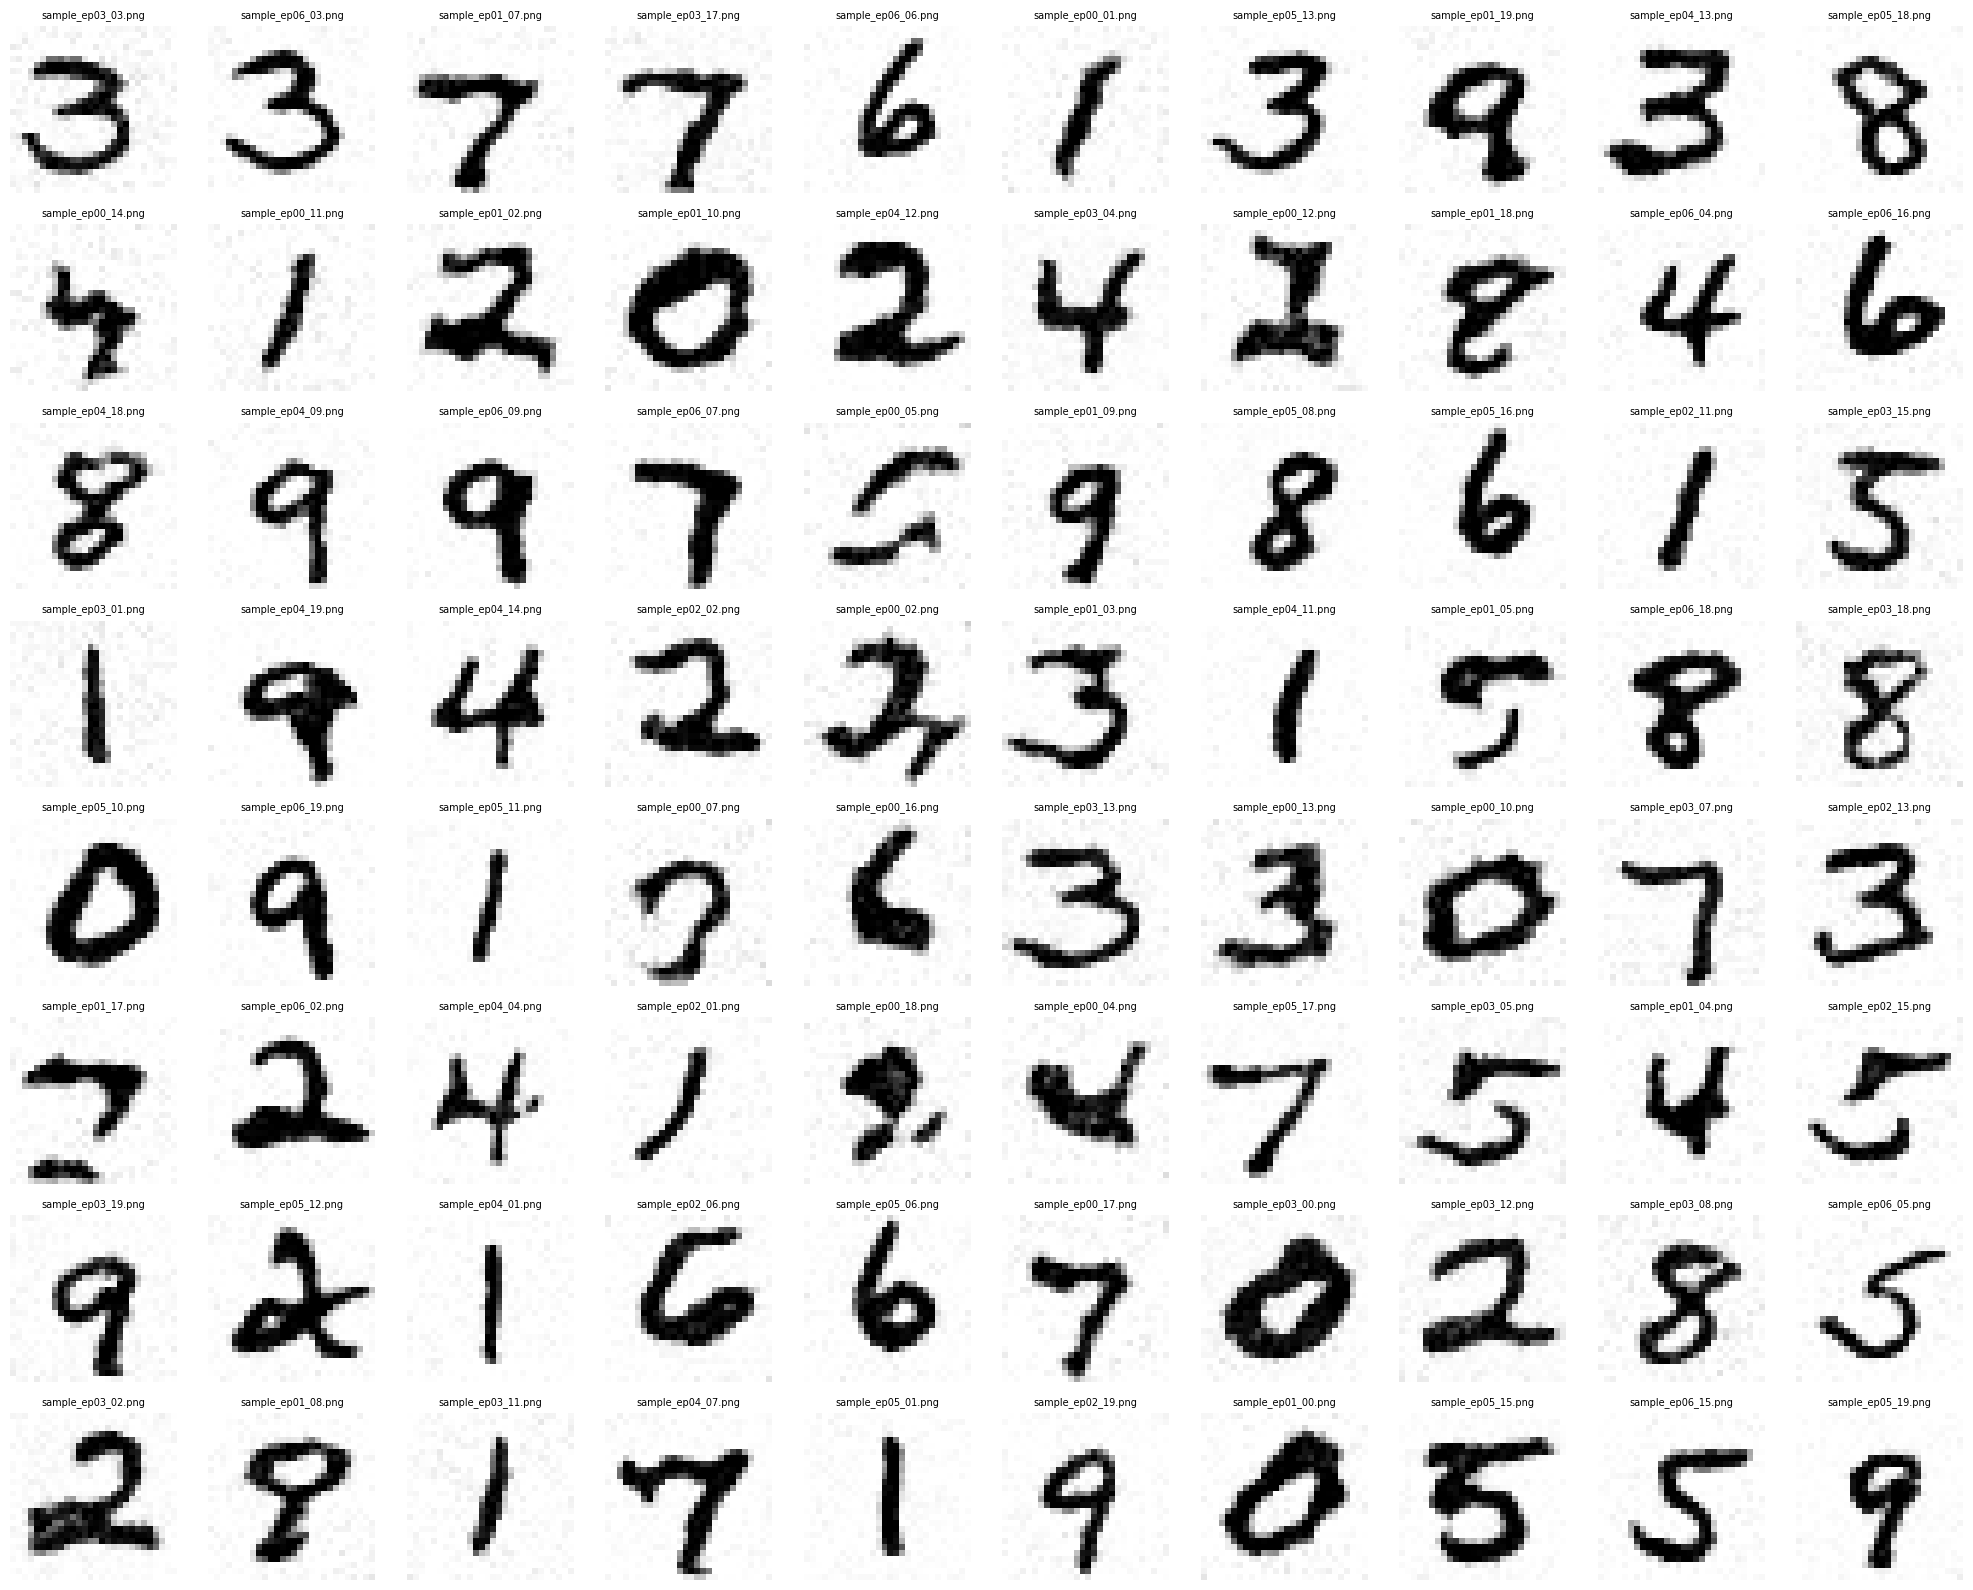

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_folder = 'diffusion_images'

image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
image_files.sort()

image_files = random.sample(image_files, min(80, len(image_files)))

n_cols = 10
n_rows = (len(image_files) + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 2, n_rows * 2))

for i, filename in enumerate(image_files):
    img_path = os.path.join(image_folder, filename)
    img = mpimg.imread(img_path)
    ax = plt.subplot(n_rows, n_cols, i + 1)
    ax.imshow(img, cmap='gray')
    ax.set_title(filename, fontsize=7)
    ax.axis('off')
    ax.set_aspect('equal')  # Giữ tỷ lệ hình vuông

plt.tight_layout()
plt.show()
